# Data Env

In [1]:
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

'''Sklearn'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')

'''gensim'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, HTML

In [2]:
#read cleaned data
from ast import literal_eval
data = pd.read_csv("../Data/StackOverflow_questions_2009_2020_cleaned.csv",
                   sep=";", index_col=0, 
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval})
data.head(5)

,Title,Body,Score,Tags
Id,,,,
4,[decimal],"[variable, trans, variable, opacity, app, erro...",792,[c#]
13,"[user, timezone]","[way, web, server, user, timezone, web, page, ...",698,[html]
19,"[way, value]","[way, value, challenge, way, constant, number,...",350,"[performance, algorithm]"
123,"[java, lib, app, csv, xml, file]","[application, library, java, data, file, file,...",120,[java]
888,"[php, script]","[php, script, debugging, error, reporting, bre...",403,"[php, eclipse]"


In [3]:
data.shape

(76060, 4)

# Preproc 

In [4]:
data["Full_doc"] = data["Title"] + data["Body"]
data["Full_doc"].head(5)

Id
4      [decimal, variable, trans, variable, opacity, ...
13     [user, timezone, way, web, server, user, timez...
19     [way, value, way, value, challenge, way, const...
123    [java, lib, app, csv, xml, file, application, ...
888    [php, script, php, script, debugging, error, r...
Name: Full_doc, dtype: object

In [5]:
#Define X & y
X = data["Full_doc"]
y = data["Tags"]

# Initialize the "CountVectorizer" for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X: (76060, 636)
Shape of y: (76060, 50)


In [6]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242, 636)
X_test shape : (22818, 636)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


# Unsurpervised Modelling 

In [7]:
# Create dic (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]]


In [8]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('app', 1),
  ('decimal', 1),
  ('error', 1),
  ('opacity', 1),
  ('trans', 1),
  ('type', 1),
  ('variable', 2)]]

In [9]:
# Build LDA model
lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.0113328380468705

Coherence Score:  0.42858266136393464


In [10]:
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(lda_model, corpus, id2word)

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.157356 -0.038001       1        1  9.402464
5     -0.117669 -0.016067       2        1  8.692464
6     -0.062822 -0.103378       3        1  6.873115
14     0.120365 -0.005249       4        1  6.236515
9      0.075225  0.037321       5        1  6.050388
19     0.043732  0.040342       6        1  5.534526
0     -0.064770 -0.018107       7        1  5.512509
16    -0.001366  0.063701       8        1  5.448961
18    -0.063319 -0.083849       9        1  4.978607
1     -0.102606  0.173227      10        1  4.504714
10     0.023370 -0.029229      11        1  4.462269
17    -0.100306 -0.041310      12        1  4.230032
12     0.003703 -0.011666      13        1  3.968359
2     -0.023651  0.005366      14        1  3.754225
13     0.126524  0.070059      15        1  3.747034
7     -0.037165 -0.002121      16        1  3.670350
3      0.003457  0.024127      17        1  3.442816
8      0.052108 -0.034383      18        1  3.370215
4      0.031888 -0.077790      19        1  3.175995
11    -0.064053  0.047006      20        1  2.944443, topic_info=          Term          Freq         Total Category  logprob  loglift
48        file  35364.000000  35364.000000  Default  30.0000  30.0000
85       class  23165.000000  23165.000000  Default  29.0000  29.0000
11      string  15506.000000  15506.000000  Default  28.0000  28.0000
5         type  18182.000000  18182.000000  Default  27.0000  27.0000
307      image  10226.000000  10226.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
14         way    827.242753  29976.584334  Topic20  -4.5127  -0.0648
34      script    548.397728   7046.223786  Topic20  -4.9238   0.9720
1183   android    561.310946   8425.424792  Topic20  -4.9005   0.8165
6     variable    505.975050   7987.928484  Topic20  -5.0043   0.7661
29      number    509.708997  14610.912595  Topic20  -4.9970   0.1696

[1718 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
7014      12  0.938058            aaaa
8037      20  0.938073       accessory
9866      15  0.869040  accountmanager
7980       7  0.973034    accumulation
10122      2  0.007526       actionbar
...      ...       ...             ...
4136      13  0.067956            zoom
4136      14  0.006796            zoom
4136      16  0.638788            zoom
4136      17  0.020387            zoom
4136      19  0.013591            zoom

[10751 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 6, 7, 15, 10, 20, 1, 17, 19, 2, 11, 18, 13, 3, 14, 8, 4, 9, 5, 12])

## LDA optimization 

In [11]:
import time
# Iteration
# best number of topics?
coherence_test = []
for k in np.arange(1,90,9):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 10
Fitting LDA for K = 19
Fitting LDA for K = 28
Fitting LDA for K = 37
Fitting LDA for K = 46
Fitting LDA for K = 55
Fitting LDA for K = 64
Fitting LDA for K = 73
Fitting LDA for K = 82


In [12]:
# coherence scores into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

,k,coherence,time
0,1,0.405238,9.361725
1,10,0.433729,17.918934
2,19,0.422732,20.012700
3,28,0.412987,21.300339
4,37,0.416835,22.542279
5,46,0.410997,25.511798
6,55,0.408126,33.954661
7,64,0.410806,42.268821
8,73,0.400848,48.899696
9,82,0.401376,132.290443


In [13]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 10


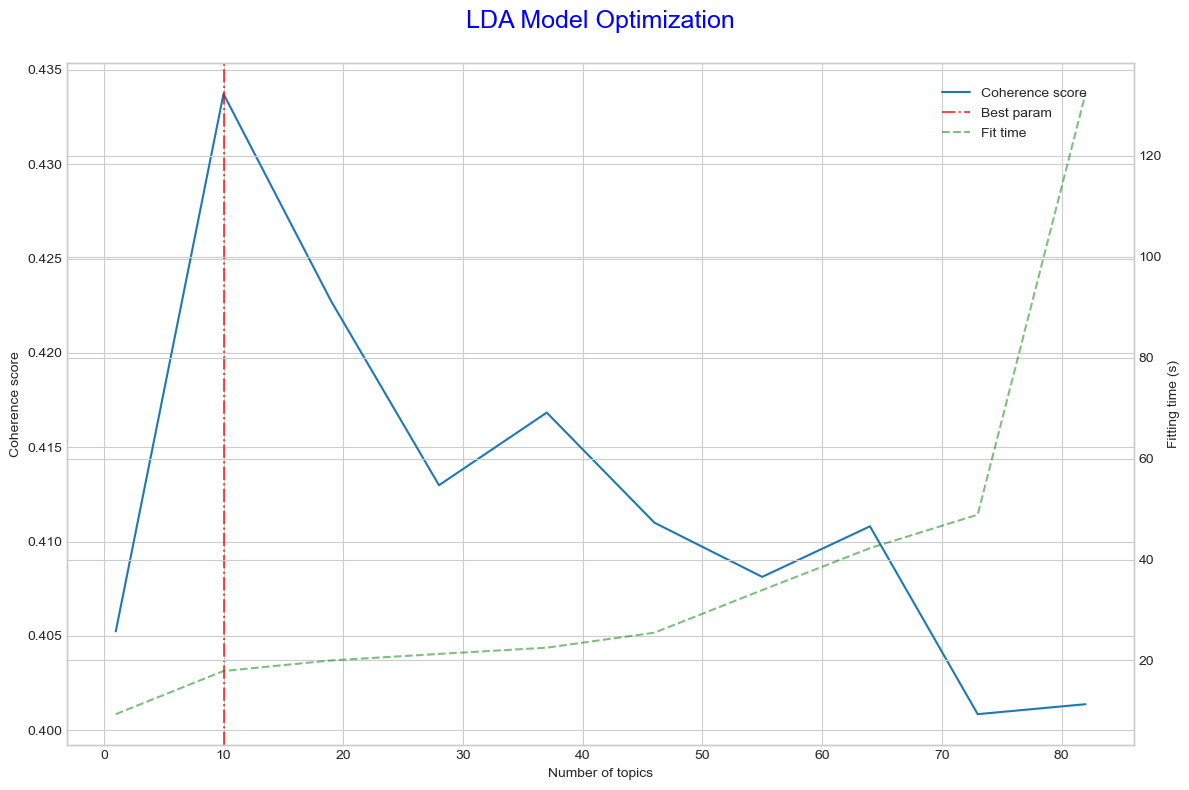

In [14]:
#Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_scores["k"]
y1 = coherence_scores["coherence"]
y2 = coherence_scores["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_topics_k, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of topics")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("LDA Model Optimization\n",
          color="blue", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

## Reducing the range of number of topics 

In [15]:
coherence_test = []
for k in np.arange(1,20,2):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 3
Fitting LDA for K = 5
Fitting LDA for K = 7
Fitting LDA for K = 9
Fitting LDA for K = 11
Fitting LDA for K = 13
Fitting LDA for K = 15
Fitting LDA for K = 17
Fitting LDA for K = 19


In [16]:
# coherence scores with the new range into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

,k,coherence,time
0,1,0.405238,8.987336
1,3,0.401154,17.529226
2,5,0.408836,16.926328
3,7,0.425425,17.694757
4,9,0.428954,18.126974
5,11,0.435295,18.931258
6,13,0.432612,18.596570
7,15,0.426824,19.964922
8,17,0.425162,20.594124
9,19,0.422075,21.524050


In [17]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 11


## Initialize with best topics number

In [18]:
#re-initialize with best topics number 
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_topics_k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
gensimvis.prepare(best_lda_model, corpus, id2word)

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.078256 -0.091495       1        1  13.802048
8     -0.116015  0.047622       2        1  12.166694
9     -0.044632  0.078913       3        1  12.077733
6     -0.003891 -0.091495       4        1  10.954794
0      0.024701 -0.051807       5        1   9.266685
1      0.152971  0.104615       6        1   7.697298
10    -0.042432  0.009023       7        1   7.484206
4     -0.069359 -0.029183       8        1   7.256616
3      0.005954  0.034531       9        1   6.760647
7      0.021499 -0.027836      10        1   6.359621
2     -0.007052  0.017111      11        1   6.173657, topic_info=         Term          Freq         Total Category  logprob  loglift
48       file  35312.000000  35312.000000  Default  30.0000  30.0000
85      class  22850.000000  22850.000000  Default  29.0000  29.0000
11     string  14803.000000  14803.000000  Default  28.0000  28.0000
307     image  10328.000000  10328.000000  Default  27.0000  27.0000
117     table  10697.000000  10697.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
47       data   1034.208377  20808.820606  Topic11  -5.0298  -0.2169
762   request    753.910476   6770.094448  Topic11  -5.3459   0.5899
223     issue    830.278081  12334.817082  Topic11  -5.2494   0.0865
137  function    904.879459  26899.501690  Topic11  -5.1634  -0.6072
13       user    757.205748  14992.629967  Topic11  -5.3415  -0.2008

[1026 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
7751      1  0.023064  acceleration
7751      2  0.107632  acceleration
7751      4  0.023064  acceleration
7751      5  0.007688  acceleration
7751      7  0.015376  acceleration
...     ...       ...           ...
3903      7  0.564030          zone
3903      8  0.018313          zone
3903      9  0.146501          zone
3903     10  0.080576          zone
3903     11  0.036625          zone

[4590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 10, 7, 1, 2, 11, 5, 4, 8, 3])

In [19]:
from imp import reload

/var/folders/_5/rhjg3s115y30bg6bd3kvpsj00000gn/T/ipykernel_51974/4113565812.py:1: DeprecationWarning:

the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses



In [20]:
#  Document X topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(corpus,
                                                minimum_probability=0))

for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)
doc_topic.head(3)

document/tag :  (76060, 50)
document/topic :  (76060, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,0.010144,0.010145,0.010142,0.010142,0.010143,0.755670,0.010143,0.010145,0.153041,0.010143,0.010143
1,0.006994,0.006994,0.156882,0.006994,0.006994,0.006994,0.006994,0.006994,0.359809,0.006994,0.427357
2,0.001977,0.001977,0.001977,0.001977,0.001977,0.484419,0.001977,0.001977,0.001977,0.001977,0.497785


In [21]:
y_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
#topic X tags matrix
# Matricial multiplication with DocumentXTopics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized) # rows represent topics
print(topic_tag.shape) # columns represent the disctribution of the associated tags
topic_tag

(11, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,361.905116,243.854081,140.485348,10.320871,93.160227,44.419123,9.656623,22.198332,703.566400,886.169182,...,36.497959,20.347754,11.584899,369.791914,195.370728,80.991636,29.916414,19.433129,73.205199,20.811810
1,92.755070,698.989866,535.573710,138.135929,51.607039,34.798157,50.357984,28.444956,289.151518,402.533090,...,43.698273,34.264398,6.832919,76.581486,40.522922,55.436605,124.303975,14.566589,26.352324,60.717299
2,246.847208,227.193988,171.104828,58.118508,61.627086,85.532439,41.214330,106.931284,181.516484,710.642535,...,61.765895,48.866038,39.880410,55.627194,31.557222,512.653259,25.562439,23.112933,47.717400,12.602016
3,177.726323,239.505492,356.341824,95.307162,26.487638,100.334721,61.166551,10.104397,113.268120,484.461512,...,31.053927,39.780253,15.109607,85.598276,43.034307,19.911183,38.132817,17.052972,47.481752,15.316577
4,327.470874,80.591544,120.871882,24.720995,26.183586,139.546988,126.569472,13.894683,98.813692,936.327717,...,42.175501,84.858236,163.373451,819.569146,533.965909,24.290644,19.624975,26.458512,51.370193,17.314786
5,337.234453,960.854549,124.416617,104.001483,928.000787,37.035825,32.395013,42.620292,1503.148278,1256.718302,...,110.677641,26.017014,8.323075,90.720107,50.408157,290.138549,182.636388,35.196510,30.960220,27.416314
6,556.414333,44.817338,277.280440,58.052928,66.311971,68.949979,53.782449,7.316059,377.731743,1650.359656,...,52.980355,30.891199,206.238173,24.219929,14.094068,71.530878,99.102653,111.503288,26.998881,55.874560
7,191.448018,99.731458,550.274151,27.289219,37.064884,53.425643,84.040744,15.383001,434.880316,641.079291,...,27.333864,30.361694,18.860666,18.523681,9.531301,63.463735,65.221988,22.691101,63.773779,45.221096
8,356.585220,20.944513,2150.012556,131.377882,14.739558,291.327935,164.616815,37.932358,174.729497,923.658071,...,81.696314,151.879246,74.012389,76.591094,127.563892,16.929944,127.908253,49.146276,158.813269,353.857427
9,361.921061,40.903721,936.096150,109.706446,32.763460,219.766459,163.646699,252.622964,316.736738,1080.424677,...,64.250025,82.338201,60.333852,35.108633,32.155921,37.278124,50.768292,318.568124,447.927025,84.128962


In [23]:
# dataframe of predictions
y_results = pd.DataFrame(y)
y_results["rep_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

In [24]:
y_results

,Tags,rep_topic,nb_tags
Id,,,
4,[c#],5,1
13,[html],10,1
19,"[performance, algorithm]",10,2
123,[java],9,1
888,"[php, eclipse]",2,2
...,...,...,...
36371706,"[arrays, performance]",5,2
36371748,"[java, spring]",9,2
36372274,[git],10,1


In [25]:
#groupby y binarized index
df_y_2 = pd.DataFrame(y_binarized)
df_dict = dict(list(df_y_2.groupby(df_y_2.index)))

#intiate a list of tags numbers 
num_tags = []
for key, value in df_dict.items():
    check = value.columns[(value == 1).any()]
    num_tags.append(check.to_list())
print(num_tags)

[[9], [20], [1, 35], [23], [15, 36], [29], [36], [0, 34, 35], [43, 44], [0, 9], [28, 44], [44], [37], [8, 10], [0, 9], [43], [0], [36], [31], [8], [40, 45], [17, 48], [8, 28], [6], [30], [12, 20], [1, 10, 34], [24], [48], [0, 9], [31, 35], [43], [47], [23], [21, 22, 48], [23], [24], [37], [31], [23], [10], [10, 35], [0, 9, 35], [37], [0, 9], [12], [23], [10], [1], [23], [23, 45], [8, 10], [9], [8, 10], [1], [9], [8], [8], [23], [19], [12], [5, 47], [8, 10], [31], [20, 24, 39], [0, 9], [37], [1, 9], [48], [8, 10], [48], [23], [45], [0, 9], [23], [44], [24], [10], [0], [0, 9], [37], [7], [37], [10], [48], [24], [24], [44], [8, 10], [36], [20], [20, 24], [9], [37], [7], [9], [36, 39], [9, 48], [20, 24], [1], [1], [37], [20], [0, 9], [15], [1, 35], [1], [10], [7, 27], [47], [24], [10, 16], [9], [23], [8], [8, 10], [0, 9], [20], [9], [47], [18, 24], [28], [5, 6], [7, 27], [0, 9], [12, 20], [1], [1, 9], [47], [17], [24], [24], [26, 40, 41], [37], [17], [12, 20], [36], [9], [7], [23], [10, 24

In [26]:
y_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
y_results["y_true"] = num_tags
y_results.head(3)

,Tags,rep_topic,nb_tags,y_true
Id,,,,
4,[c#],5,1,[9]
13,[html],10,1,[20]
19,"[performance, algorithm]",10,2,"[1, 35]"


In [28]:
# Selecting predicted tags from Topics X Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.rep_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

/var/folders/_5/rhjg3s115y30bg6bd3kvpsj00000gn/T/ipykernel_51974/1552659229.py:6: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



,Tags,rep_topic,nb_tags,y_true,y_pred
Id,,,,,
4,[c#],5,1,[9],[10]
13,[html],10,1,[20],[23]
19,"[performance, algorithm]",10,2,"[1, 35]","[23, 24]"


## LDA Model evaluation

In [29]:
metrics

<module 'sklearn.metrics' from '/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/__init__.py'>

In [30]:
def metrics_scores(model, df, y_true, y_pred):
    if(df is not None):
        scores_df = df
    else:
        scores_df = pd.DataFrame(index=["Accuracy", "F1",
                                         "Recall",
                                         "Precision"],
                                          columns=[model])
    #intiate scores' list
    scores = []
    #append scores
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    scores_df[model] = scores
    
    return scores_df

In [31]:
# Create matrix for predicted and true tags y
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [32]:
#create df of lds metrics chosen above
df_metrics = metrics_scores("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,LDA
Accuracy,0.136221
F1,0.287827
Recall,0.225498
Precision,0.161093


**LDA non supervised approach is not adapted seen the scores results.**

# Supervised Approach 

## Logistic Regression

### Logit Grid search

In [33]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

#Grid search best params
multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [34]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [35]:
logit_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,170.155810,5.354002,0.196643,0.017726,100,False,l1,liblinear,"{'estimator__C': 100, 'estimator__dual': False...",0.576148,...,0.574762,0.002243,4,0.642567,0.642560,0.643615,0.647790,0.644800,0.644267,0.001945
1,48.721768,1.475712,0.223809,0.046149,100,False,l2,liblinear,"{'estimator__C': 100, 'estimator__dual': False...",0.580745,...,0.580646,0.001777,2,0.634849,0.634559,0.635708,0.639159,0.636971,0.636249,0.001679
2,81.531246,2.837163,0.202699,0.033170,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.582487,...,0.581833,0.001463,1,0.629974,0.629727,0.630663,0.633526,0.632221,0.631222,0.001443
3,26.012298,0.354592,0.193678,0.026115,10,False,l2,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.578405,...,0.577189,0.001247,3,0.615259,0.614406,0.615599,0.618281,0.616364,0.615982,0.001310
4,29.599326,0.522936,0.209962,0.023560,1.0,False,l1,liblinear,"{'estimator__C': 1.0, 'estimator__dual': False...",0.569728,...,0.567431,0.001612,5,0.584695,0.583791,0.584114,0.587544,0.584572,0.584943,0.001340
5,15.999605,0.224221,0.194595,0.017970,1.0,False,l2,liblinear,"{'estimator__C': 1.0, 'estimator__dual': False...",0.540823,...,0.539112,0.002224,6,0.557612,0.556724,0.557880,0.559746,0.558826,0.558158,0.001039
6,11.252160,0.219080,0.184178,0.023200,0.1,False,l1,liblinear,"{'estimator__C': 0.1, 'estimator__dual': False...",0.487132,...,0.484505,0.003435,7,0.486660,0.485570,0.487991,0.489025,0.489563,0.487762,0.001477
7,8.757006,0.747470,0.100538,0.035475,0.1,False,l2,liblinear,"{'estimator__C': 0.1, 'estimator__dual': False...",0.356205,...,0.351351,0.003655,8,0.354953,0.356731,0.358757,0.358854,0.358088,0.357477,0.001472


In [36]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,81.531246,2.837163,0.202699,0.03317,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.582487,...,0.581833,0.001463,1,0.629974,0.629727,0.630663,0.633526,0.632221,0.631222,0.001443


###  Logit Predictions

In [37]:
# Predict
y_test_predicted_labels = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('java',), ('html', 'javascript'), ('google-chrome', 'javascript'), ('android',), ('android',)]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [38]:
#Evaluation
df_metrics_logit = metrics_scores("Logit", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels)
df_metrics_logit

,LDA,Logit
Accuracy,0.136221,0.341835
F1,0.287827,0.616698
Recall,0.225498,0.487326
Precision,0.161093,0.744606


## Random Forest

### Grid Search

In [39]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=5,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on sampled data to reduce fitting time
multi_rfc_cv.fit(X_train[0:5000], y_train[0:5000])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [40]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5}


In [41]:
#formatting for the arguments of the Model 
rfc_best_params_arg = {}
for k, v in rfc_best_params.items():
    rfc_best_params_arg[k.replace("estimator__","")] = v

In [42]:
# Refit RandomForestClassifier with best_params on full data
rfc_best_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_arg))
rfc_best_model.fit(X_train, y_train)

[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=1;, score=(train=0.712, test=0.536) total time=  19.7s
[CV 3/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=10;, score=(train=0.637, test=0.539) total time=  21.2s
[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.815, test=0.550) total time=  37.2s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.814, test=0.541) total time=  36.8s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=1;, score=(train=0.997, test=0.346) total time=  48.6s
[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=5;, score=(train=0.664, test=0.532) total time=  19.3s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=5, e

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=25,
                                                     min_samples_leaf=5))

### Predict

In [43]:
# Predict
y_test_predicted_labels_rfc = rfc_best_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_rfc)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('eclipse', 'java'), ('css', 'html', 'javascript'), ('android', 'html', 'javascript', 'jquery'), ('android',), ('android', 'ios', 'iphone', 'objective-c')]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [44]:
#Evaluation
df_metrics_rfc = metrics_scores("RandomForest", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_rfc)
df_metrics_rfc

,LDA,Logit,RandomForest
Accuracy,0.136221,0.341835,0.222763
F1,0.287827,0.616698,0.569583
Recall,0.225498,0.487326,0.733271
Precision,0.161093,0.744606,0.528711


## Unpredicted tags

Giving that Logistic regression and Random Forest models perform quite on a similar steak of evaluation, they seem coherent with the data. to be able to tell them apart, we shall see **the number of rows where tags weren't predicted**: 

In [45]:
#tags per row for y_pred logit
Tags_row_logit = y_test_predicted_labels.sum(axis=1)
null_rate_logit = round(((Tags_row_logit.size - np.count_nonzero(Tags_row_logit))
                      /Tags_row_logit.size)*100,2)

#tags per row for y_pred rfc
Tags_row_rfc = y_test_predicted_labels_rfc.sum(axis=1)
null_rate_rfc = round(((Tags_row_rfc.size - np.count_nonzero(Tags_row_rfc))
                       /Tags_row_rfc.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_logit))
print("Random Forest: {}%".format(null_rate_rfc))

--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 28.44%
Random Forest: 4.71%


Random Forest model seems more adequate to this multi classification task.

# Neural networks

In [65]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
# NN dependencies 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
from tensorflow.keras import Sequential, layers
from gensim.models import Word2Vec

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:18: DeprecationWarning:

Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:36: DeprecationWarning:

Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/tensorflow/core/framework/tensor_shape_pb2.py:43: DeprecationWarning:

Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.

/U

In [47]:
# new holdout
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242,)
X_test shape : (22818,)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


In [48]:
X_train

Id
24407931    [java, lambda, expression, iteration, folk, ex...
15140370    [localdb, instance, name, sql, script, sql, se...
20148       [myisam, innodb, project, lot, database, inser...
19145332    [nltk, counting, frequency, bigram, python, nl...
34307379    [table, element, function, table, code, line, ...
                                  ...                        
4937263     [object, networking, number, system, idea, net...
28761365    [promise, story, promise, way, promise, error,...
8167754     [postgres, architecture, app, instance, nginx,...
11165200    [list, view, method, child, publication, item,...
32805916    [compute, jaccard, matrix, matrix, sparsecsr_m...
Name: Full_doc, Length: 53242, dtype: object

## WOR2VEC Embedding

In [51]:
word2vec = gensim.models.Word2Vec(sentences=X_train,
                                  vector_size=300,
                                  min_count=1,
                                  window=10)

In [52]:
#embedding functions 
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

def embedding(word2vec, sentences):
    '''function that, given a list of sentence (each sentence being a list of words/strings),
    returns a list of embedded sentences (each sentence is a matrix).'''
    
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
   

In [53]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

In [54]:
#assertions
assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

In [55]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def jaccard_m(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [57]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(150, activation='tanh'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(150, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(50, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1_m, recall_m, precision_m])
    
    return model

model = init_model()

In [72]:
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

0.0

In [74]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [75]:
from tensorflow.keras.utils import Sequence
 

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train_pad, y_train, 32)
test_gen = DataGenerator(X_test_pad, y_test, 32)


In [76]:
history = model.fit(train_gen,
                    epochs=6,
                    validation_data=test_gen,
                   verbose=0)

2023-02-19 12:05:00.573686: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-19 12:05:03.752591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 12:05:04.283885: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2023-02-19 12:05:04.290512: I tensorflow/core/grappler/optimizers/custom_graph_optimiz

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_5' defined at (most recent call last):
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/_5/rhjg3s115y30bg6bd3kvpsj00000gn/T/ipykernel_51974/3392048302.py", line 1, in <module>
      history = model.fit(train_gen,
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_5'
could not find registered platform with id: 0x2ab68fcc0
	 [[{{node StatefulPartitionedCall_5}}]] [Op:__inference_train_function_9394]

In [71]:
# Run training on GPU

history = model.fit(X_train_pad, y_train,
                          epochs=20,
                          batch_size=32,
                          verbose=0,
                          validation_data=(X_test_pad, y_test),
                          shuffle=True)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [67]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1
